# ShopTalk — ABO EDA & Embedding Model Comparison

**Goal**: Load the Amazon Berkeley Objects (ABO) dataset metadata, run quick EDA, generate embeddings with multiple pretrained models, and compare retrieval quality & clustering.

**Output**:
- Cleaned product text (title + description + optional captions)
- Embeddings from several encoders (e5 / bge / MiniLM; easily extendable)
- Retrieval metrics (Recall@K, nDCG@K) on a small eval set
- Inter-/intra-category cosine analysis
- UMAP projection plots

> ⚠️ This notebook downloads data from the web (ABO) and models from Hugging Face. Run in an environment with internet (Colab/Kaggle) and a GPU for speed.

## 0. Setup

Configure your environment and pick which encoders to benchmark.

In [ ]:
!pip -q install pandas numpy matplotlib umap-learn scikit-learn faiss-cpu sentence-transformers datasets rich

from pathlib import Path
import pandas as pd, numpy as np
from rich import print
DATA_DIR = Path('./data_abo')
DATA_DIR.mkdir(exist_ok=True)

# Choose encoders to compare
ENCODERS = {
    'e5-base': 'intfloat/e5-base-v2',
    'bge-base': 'BAAI/bge-base-en-v1.5',
    'MiniLM': 'sentence-transformers/all-MiniLM-L6-v2'
}
SEED = 42
np.random.seed(SEED)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 40.6 MB/s eta 0:00:00


## 1. Download ABO metadata (sample) & optional images

ABO host: https://amazon-berkeley-objects.s3.amazonaws.com/index.html  
We'll pull a metadata CSV/JSONL sample (titles, categories, descriptions, URLs).

In [ ]:
import os
from pathlib import Path
import urllib.request

DATA_DIR = Path("./data_abo")
DATA_DIR.mkdir(parents=True, exist_ok=True)

url = "https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-listings.tar"
tar_path = DATA_DIR / "abo-listings.tar"

if tar_path.exists() and tar_path.stat().st_size > 0:
    print("Using cached:", tar_path)
else:
    print("Downloading:", url)
    urllib.request.urlretrieve(url, str(tar_path))
    print("Saved to:", tar_path)


Downloading: https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-listings.tar

Saved to: data_abo/abo-listings.tar

In [ ]:
import tarfile

with tarfile.open(tar_path, "r:*") as tar:
    members = tar.getmembers()
    print("Entries in tar:", len(members))
    # show the first 30 items so you get a sense of structure
    for m in members[:30]:
        kind = "DIR " if m.isdir() else "FILE"
        size_mb = f"{m.size/1e6:.2f} MB" if m.isfile() else ""
        print(f"{kind:4} {m.name} {size_mb}")

# Extract only *.json.gz files
extract_dir = DATA_DIR / "json_gz_files"
extract_dir.mkdir(parents=True, exist_ok=True)

with tarfile.open(tar_path, "r:*") as tar:
    for m in tar.getmembers():
        if m.isfile() and m.name.endswith(".json.gz"):
            print("Extracting:", m.name)
            tar.extract(m, path=extract_dir)

print("Done. Extracted to:", extract_dir)


Entries in tar: 20

FILE LICENSE-CC-BY-4.0.txt 0.01 MB

DIR  listings

FILE listings/README.md 0.01 MB

DIR  listings/metadata

FILE listings/metadata/listings_7.json.gz 5.43 MB

FILE listings/metadata/listings_4.json.gz 5.55 MB

FILE listings/metadata/listings_2.json.gz 5.45 MB

FILE listings/metadata/listings_c.json.gz 5.44 MB

FILE listings/metadata/listings_6.json.gz 5.50 MB

FILE listings/metadata/listings_0.json.gz 5.45 MB

FILE listings/metadata/listings_9.json.gz 5.50 MB

FILE listings/metadata/listings_e.json.gz 5.50 MB

FILE listings/metadata/listings_1.json.gz 5.35 MB

FILE listings/metadata/listings_5.json.gz 5.58 MB

FILE listings/metadata/listings_3.json.gz 5.39 MB

FILE listings/metadata/listings_d.json.gz 5.41 MB

FILE listings/metadata/listings_f.json.gz 5.46 MB

FILE listings/metadata/listings_8.json.gz 5.57 MB

FILE listings/metadata/listings_a.json.gz 5.46 MB

FILE listings/metadata/listings_b.json.gz 5.41 MB

Extracting: listings/metadata/listings_7.json.gz

/tmp/ipython-input-192324685.py:20: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extract(m, path=extract_dir)


Extracting: listings/metadata/listings_4.json.gz

Extracting: listings/metadata/listings_2.json.gz

Extracting: listings/metadata/listings_c.json.gz

Extracting: listings/metadata/listings_6.json.gz

Extracting: listings/metadata/listings_0.json.gz

Extracting: listings/metadata/listings_9.json.gz

Extracting: listings/metadata/listings_e.json.gz

Extracting: listings/metadata/listings_1.json.gz

Extracting: listings/metadata/listings_5.json.gz

Extracting: listings/metadata/listings_3.json.gz

Extracting: listings/metadata/listings_d.json.gz

Extracting: listings/metadata/listings_f.json.gz

Extracting: listings/metadata/listings_8.json.gz

Extracting: listings/metadata/listings_a.json.gz

Extracting: listings/metadata/listings_b.json.gz

Done. Extracted to: data_abo/json_gz_files

In [ ]:
import gzip
import json
import pandas as pd
from pathlib import Path

# Where you extracted the tar file
extract_dir = Path("data_abo/json_gz_files")

# Find all .json.gz files
json_gz_files = list(extract_dir.rglob("*.json.gz"))
print("Found", len(json_gz_files), "json.gz files")

rows = []

# Read all files line by line
for file in json_gz_files:
    print("Reading:", file)
    with gzip.open(file, "rt", encoding="utf-8") as f:
        for line in f:
            try:
                rows.append(json.loads(line))
            except Exception as e:
                print(f"Skipping bad line in {file}: {e}")

# Convert to DataFrame
df = pd.DataFrame(rows)
print("Combined shape:", df.shape)
print(df.head(5))


Found 16 json.gz files

Reading: data_abo/json_gz_files/listings/metadata/listings_1.json.gz

Reading: data_abo/json_gz_files/listings/metadata/listings_b.json.gz

Reading: data_abo/json_gz_files/listings/metadata/listings_e.json.gz

Reading: data_abo/json_gz_files/listings/metadata/listings_a.json.gz

Reading: data_abo/json_gz_files/listings/metadata/listings_8.json.gz

Reading: data_abo/json_gz_files/listings/metadata/listings_5.json.gz

Reading: data_abo/json_gz_files/listings/metadata/listings_6.json.gz

Reading: data_abo/json_gz_files/listings/metadata/listings_0.json.gz

Reading: data_abo/json_gz_files/listings/metadata/listings_4.json.gz

Reading: data_abo/json_gz_files/listings/metadata/listings_2.json.gz

Reading: data_abo/json_gz_files/listings/metadata/listings_d.json.gz

Reading: data_abo/json_gz_files/listings/metadata/listings_9.json.gz

Reading: data_abo/json_gz_files/listings/metadata/listings_f.json.gz

Reading: data_abo/json_gz_files/listings/metadata/listings_7.json.gz

Reading: data_abo/json_gz_files/listings/metadata/listings_3.json.gz

Reading: data_abo/json_gz_files/listings/metadata/listings_c.json.gz

Combined shape:
(147702, 28)

brand  \
0  [{'language_tag': 'en_IN', 'value': 'Amazon Br...   
1  [{'language_tag': 'es_MX', 'value': 'Amazon Co...   
2  [{'language_tag': 'en_IN', 'value': 'Amazon Br...   
3  [{'language_tag': 'en_IN', 'value': 'Amazon Br...   
4  [{'language_tag': 'en_IN', 'value': 'Amazon Br...   

                                        bullet_point  \
0  [{'language_tag': 'en_IN', 'value': '3D Printe...   
1  [{'language_tag': 'es_MX', 'value': 'Tenis col...   
2  [{'language_tag': 'en_IN', 'value': '3D Printe...   
3  [{'language_tag': 'en_IN', 'value': 'Snug fit ...   
4  [{'language_tag': 'en_IN', 'value': 'Snug fit ...   

                                               color     item_id  \
0  [{'language_tag': 'en_IN', 'standardized_value...  B07TGZZMDK   
1  [{'language_tag': 'es_MX', 'value': 'Rose-gold...  B00NFSDXR6   
2  [{'language_tag': 'en_IN', 'standardized_value...  B07T6M3Y35   
3  [{'language_tag': 'en_IN', 'standardized_value...  B0857L527B   
4  [{'language_tag': 'en_IN', 'standardized_value...  B0853X2GXR   

                                           item_name  \
0  [{'language_tag': 'en_IN', 'value': 'Amazon Br...   
1  [{'language_tag': 'es_MX', 'value': 'Amazon Co...   
2  [{'language_tag': 'en_IN', 'value': 'Amazon Br...   
3  [{'language_tag': 'en_IN', 'value': 'Amazon Br...   
4  [{'language_tag': 'en_IN', 'value': 'Amazon Br...   

                                         item_weight  \
0  [{'normalized_value': {'unit': 'pounds', 'valu...   
1                                                NaN   
2  [{'normalized_value': {'unit': 'pounds', 'valu...   
3  [{'normalized_value': {'unit': 'pounds', 'valu...   
4  [{'normalized_value': {'unit': 'pounds', 'valu...   

                                          model_name  \
0  [{'language_tag': 'en_IN', 'value': 'Coolpad C...   
1                                                NaN   
2  [{'language_tag': 'en_IN', 'value': 'Xiaomi Re...   
3  [{'language_tag': 'en_IN', 'value': 'Coolpad M...   
4    [{'language_tag': 'en_IN', 'value': 'Poco X2'}]   

                      model_number                               product_type  \
0    [{'value': 'gz8365-SL40381'}]         [{'value': 'CELLULAR_PHONE_CASE'}]   
1  [{'value': 'N1195105_150_000'}]  [{'value': 'FINENECKLACEBRACELETANKLET'}]   
2    [{'value': 'gz8116-SL40635'}]         [{'value': 'CELLULAR_PHONE_CASE'}]   
3   [{'value': 'UV10335-SL12146'}]         [{'value': 'CELLULAR_PHONE_CASE'}]   
4    [{'value': 'gz8755-SL40563'}]         [{'value': 'CELLULAR_PHONE_CASE'}]   

  main_image_id  ...                                      style  \
0   81UMw96Q7OL  ...                                        NaN   
1   81kyR6s99yL  ...  [{'language_tag': 'es_MX', 'value': '0'}]   
2   71fk+2A-BuL  ...                                        NaN   
3   71FFxVAZviL  ...                                        NaN   
4   719vW-ko0DL  ...                                        NaN   

  item_dimensions model_year color_code fabric_type spin_id 3dmodel_id  \
0             NaN        NaN        NaN         NaN     NaN        NaN   
1             NaN        NaN        NaN         NaN     NaN        NaN   
2             NaN        NaN        NaN         NaN     NaN        NaN   
3             NaN        NaN        NaN         NaN     NaN        NaN   
4             NaN        NaN        NaN         NaN     NaN        NaN   

  finish_type product_description pattern  
0         NaN                 NaN     NaN  
1         NaN                 NaN     NaN  
2         NaN                 NaN     NaN  
3         NaN                 NaN     NaN  
4         NaN                 NaN     NaN  

[5 rows x 28 columns]

In [ ]:
# import os, urllib.request, json, gzip, io

# # Example: ABO provides category-level json/tsv. Adjust paths as needed based on their index.
# BASE_URL = 'https://amazon-berkeley-objects.s3.amazonaws.com/listings/metadata/'
# META_DIR = DATA_DIR / 'metadata_products'
# META_DIR.mkdir(parents=True, exist_ok=True)
# parts = [f"listings_{i}.json.gz" for i in range(4)]
# for fname in parts:
#   url = BASE_URL + fname
#   TARGET = META_DIR / fname
#   if not TARGET.exists():
#       print(f'Downloading: {url}')
#       urllib.request.urlretrieve(url, TARGET)
#   else:
#       print('Using cached file:', TARGET)

# rows = []
# for fname in parts:
#   target = META_DIR / fname
#   with gzip.open(target, 'rb') as f:
#       for line in f:
#           rows.append(json.loads(line))
# df = pd.DataFrame(rows)
# print(df.shape)
# df.head(3)

Downloading: https://amazon-berkeley-objects.s3.amazonaws.com/listings/metadata/listings_0.json.gz

Downloading: https://amazon-berkeley-objects.s3.amazonaws.com/listings/metadata/listings_1.json.gz

Downloading: https://amazon-berkeley-objects.s3.amazonaws.com/listings/metadata/listings_2.json.gz

Downloading: https://amazon-berkeley-objects.s3.amazonaws.com/listings/metadata/listings_3.json.gz

(36928, 28)

,brand,bullet_point,color,item_id,item_name,model_name,model_number,model_year,product_type,style,...,item_weight,material,fabric_type,color_code,product_description,spin_id,3dmodel_id,pattern,finish_type,item_shape
0,"[{'language_tag': 'nl_NL', 'value': 'find.'}]","[{'language_tag': 'nl_NL', 'value': 'Schoen in...","[{'language_tag': 'nl_NL', 'value': 'Veelkleur...",B06X9STHNG,"[{'language_tag': 'nl_NL', 'value': 'Amazon-me...","[{'language_tag': 'nl_NL', 'value': '37753'}]",[{'value': '12-05-04'}],[{'value': 2017}],[{'value': 'SHOES'}],"[{'language_tag': 'nl_NL', 'value': 'Gesloten-...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'language_tag': 'es_MX', 'value': 'AmazonBas...","[{'language_tag': 'es_MX', 'value': 'White Pow...","[{'language_tag': 'es_MX', 'value': 'White Pow...",B07P8ML82R,"[{'language_tag': 'es_MX', 'value': '22"" Botto...",NaN,[{'value': 'AB5013-R22-10'}],NaN,[{'value': 'HARDWARE'}],"[{'language_tag': 'es_MX', 'value': '10 pares'}]",...,"[{'normalized_value': {'unit': 'pounds', 'valu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[{'language_tag': 'en_AE', 'value': 'AmazonBas...","[{'language_tag': 'en_AE', 'value': '3D printe...","[{'language_tag': 'en_AE', 'value': 'Transluce...",B07H9GMYXS,"[{'language_tag': 'en_AE', 'value': 'AmazonBas...",NaN,[{'value': 'AMG10528516-10'}],NaN,[{'value': 'MECHANICAL_COMPONENTS'}],"[{'language_tag': 'en_AE', 'value': '1-Pack'}]",...,"[{'normalized_value': {'unit': 'pounds', 'valu...","[{'language_tag': 'en_AE', 'value': 'PETG (Pol...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Text fields & simple cleaning
We construct a unified `text_for_embed` field: title + description + (optional) captions.

In [ ]:
# 1) If some columns are JSON stored as strings, parse them
def parse_json_if_needed(x):
    if isinstance(x, str):
        s = x.strip()
        if s and ((s[0] == '{' and s[-1] == '}') or (s[0] == '[' and s[-1] == ']')):
            try:
                return json.loads(s)
            except Exception:
                return x
    return x

df = df.applymap(parse_json_if_needed)

# 2) Extract semantic text from dict/list/primitive
def extract_value(obj):
    if obj is None:
        return ''
    if isinstance(obj, str):
        return obj.strip()
    if isinstance(obj, (int, float, bool)):
        return str(obj)
    if isinstance(obj, dict):
        # Prefer a 'value' field if present
        if 'value' in obj:
            return extract_value(obj['value'])
        # Else join all leaf values
        return ' '.join(extract_value(v) for v in obj.values())
    if isinstance(obj, list):
        return ' '.join(extract_value(el) for el in obj)
    return ''



def coalesce_row(row):
    parts = []
    for c in text_cols:
        parts.append(extract_value(row.get(c, '')))
    # Clean spaces and collapse
    text = ' '.join(p for p in parts if p)
    return ' '.join(text.split())



text_cols = df.select_dtypes(include=['object']).columns.tolist()

exclude_cols = {'item_id', 'spin_id','3dmodel_id'}
text_cols = [c for c in text_cols if c not in exclude_cols]

df['text_for_embed'] = df[text_cols].apply(coalesce_row, axis=1)

# Drop rows with empty text
df = df[df['text_for_embed'].str.strip().astype(bool)].reset_index(drop=True)

print("Text columns used:", text_cols)

df[['text_for_embed']].head(3)

/tmp/ipython-input-2657168963.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(parse_json_if_needed)


Text columns used:
[
    'brand',
    'bullet_point',
    'color',
    'item_name',
    'item_weight',
    'model_name',
    'model_number',
    'product_type',
    'main_image_id',
    'other_image_id',
    'item_keywords',
    'country',
    'marketplace',
    'domain_name',
    'node',
    'item_shape',
    'material',
    'style',
    'item_dimensions',
    'model_year',
    'color_code',
    'fabric_type',
    'finish_type',
    'product_description',
    'pattern'
]

,text_for_embed
0,Amazon Brand - Solimo 3D Printed Hard Back Cas...
1,Amazon Collection Tenis collar en plata de ley...
2,Amazon Brand - Solimo 3D Printed Hard Back Cas...


## 3. Quick EDA
- Basic counts per category
- Text length distributions
- Missing values

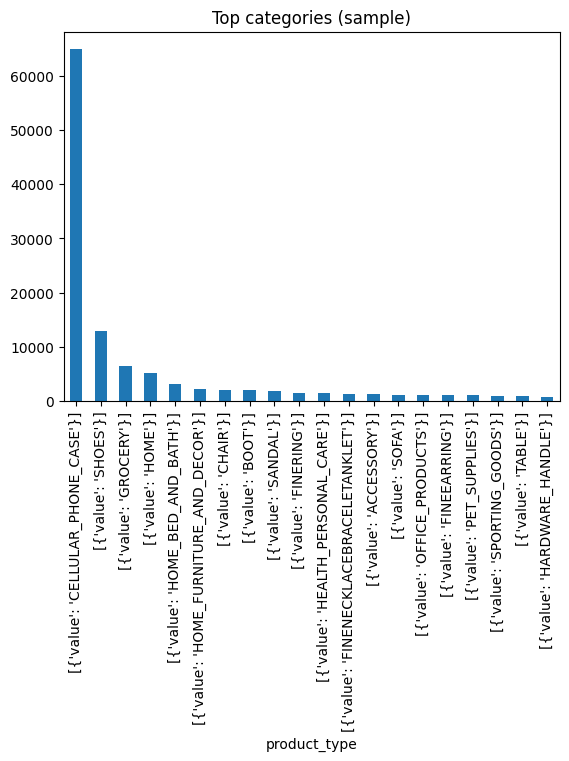

In [ ]:
ax = df['product_type'].astype(str).value_counts().head(20).plot(kind='bar', title='Top categories (sample)')

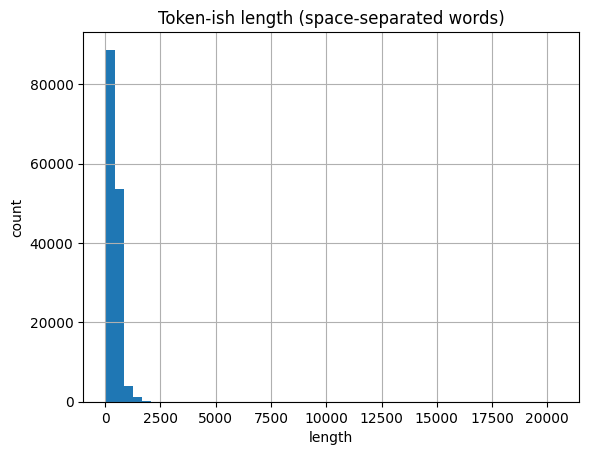

In [ ]:
import matplotlib.pyplot as plt

df['len_text'] = df['text_for_embed'].str.split().apply(len)

ax = df['len_text'].hist(bins=50)
ax.set_title('Token-ish length (space-separated words)')
ax.set_xlabel('length'); ax.set_ylabel('count')
plt.show()


## 4. Embedding models wrapper
A common interface to swap models (e5/bge/MiniLM).

In [ ]:
from sentence_transformers import SentenceTransformer
import torch, math

class Encoder:
    def __init__(self, model_name: str, device: str | None = None):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name, device=device)
    def encode(self, texts, batch_size=128, normalize=True):
        embs = self.model.encode(texts, batch_size=batch_size, convert_to_numpy=True, show_progress_bar=True, normalize_embeddings=normalize)
        return embs

encoders = {alias: Encoder(m) for alias, m in ENCODERS.items()}
list(encoders.keys())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

['e5-base', 'bge-base', 'MiniLM']

## 5. Create a small eval set (queries ↔ positives)
We synthesize simple queries from product rows (title + constraints). In real use, label true pairs or mine from click logs.

In [ ]:
def make_query(row):
    t = str(row['item_name']).lower()
    cat = str(row['product_type']).split('/')[-1] if row['product_type'] else ''
    # very naive query synthesis
    return f"{cat} {t}".strip()

sample = df.sample(n=min(2000, len(df)), random_state=SEED).reset_index(drop=True)
sample['query'] = sample.apply(make_query, axis=1)
sample[['item_name','product_type','query']].head(5)

,item_name,product_type,query
0,"[{'language_tag': 'en_US', 'value': '365 Every...",[{'value': 'GROCERY'}],[{'value': 'GROCERY'}] [{'language_tag': 'en_u...
1,"[{'language_tag': 'en_SG', 'value': 'AmazonBas...",[{'value': 'BODY_POSITIONER'}],[{'value': 'BODY_POSITIONER'}] [{'language_tag...
2,"[{'language_tag': 'en_IN', 'value': 'Amazon Br...",[{'value': 'CELLULAR_PHONE_CASE'}],[{'value': 'CELLULAR_PHONE_CASE'}] [{'language...
3,"[{'language_tag': 'en_IN', 'value': 'Amazon Br...",[{'value': 'CELLULAR_PHONE_CASE'}],[{'value': 'CELLULAR_PHONE_CASE'}] [{'language...
4,"[{'language_tag': 'en_US', 'value': 'RED WAGON...",[{'value': 'SHOES'}],[{'value': 'SHOES'}] [{'language_tag': 'en_us'...


## 6. Compute embeddings per model

In [ ]:
texts = sample['text_for_embed'].tolist()
queries = sample['query'].tolist()

EMB = {}
for name, enc in encoders.items():
    print(f"Encoding with {name} ...")
    EMB[(name,'docs')] = enc.encode(texts)
    EMB[(name,'queries')] = enc.encode(queries)
print({k[0] for k in EMB.keys()})

Encoding with e5-base ...

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Encoding with bge-base ...

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Encoding with MiniLM ...

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

{'bge-base', 'e5-base', 'MiniLM'}

## 7. Retrieval metrics (Recall@K, nDCG@K)
Each query's positive is the row-aligned product (index match). We'll also include **hard negatives** via nearest categories to stress the model.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recall_at_k(sim, k=10):
    # sim: Q x D cosine matrix, positives are diag
    topk = np.argsort(-sim, axis=1)[:, :k]
    hits = np.any(topk == np.arange(sim.shape[0])[:,None], axis=1)
    return hits.mean()

def ndcg_at_k(sim, k=10):
    # relevance: 1 for the diagonal positive else 0
    Q = sim.shape[0]
    ndcgs = []
    for i in range(Q):
        ranks = np.argsort(-sim[i])[:k]
        rels = (ranks == i).astype(float)
        dcg = np.sum(rels / np.log2(np.arange(2, k+2)))
        idcg = 1.0  # best possible is 1 at rank 1
        ndcgs.append(dcg / idcg)
    return float(np.mean(ndcgs))

metrics = []
for name in ENCODERS.keys():
    q = EMB[(name,'queries')]
    d = EMB[(name,'docs')]
    sim = cosine_similarity(q, d)
    r10 = recall_at_k(sim, k=10)
    n10 = ndcg_at_k(sim, k=10)
    metrics.append({"model": name, "Recall@10": r10, "nDCG@10": n10})
pd.DataFrame(metrics)

,model,Recall@10,nDCG@10
0,e5-base,0.9520,0.867032
1,bge-base,0.8655,0.726452
2,MiniLM,0.6380,0.457795


## 8. Inter-/Intra-category cosine analysis
Measure how well embeddings separate categories by comparing normalized intra vs inter-category similarities.

In [ ]:
def inter_intra_scores(emb, cats):
    cats = np.array(cats)
    sim = cosine_similarity(emb)
    intra, inter = [], []
    for i in range(len(emb)):
        same = (cats == cats[i])
        diff = ~same
        intra.append(sim[i, same].mean())
        inter.append(sim[i, diff].mean())
    return float(np.mean(intra)), float(np.mean(inter))

cat_labels = sample['product_type'].astype(str).tolist()
rows = []
for name in ENCODERS.keys():
    intra, inter = inter_intra_scores(EMB[(name,'docs')], cat_labels)
    rows.append({"model": name, "intra_cos": intra, "inter_cos": inter, "delta": intra - inter})
pd.DataFrame(rows).sort_values('delta', ascending=False)

,model,intra_cos,inter_cos,delta
2,MiniLM,0.642779,0.193428,0.449350
1,bge-base,0.796423,0.575004,0.221419
0,e5-base,0.899883,0.800527,0.099356


## 9. UMAP visualization
Project embeddings to 2D to visually inspect clustering by category.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


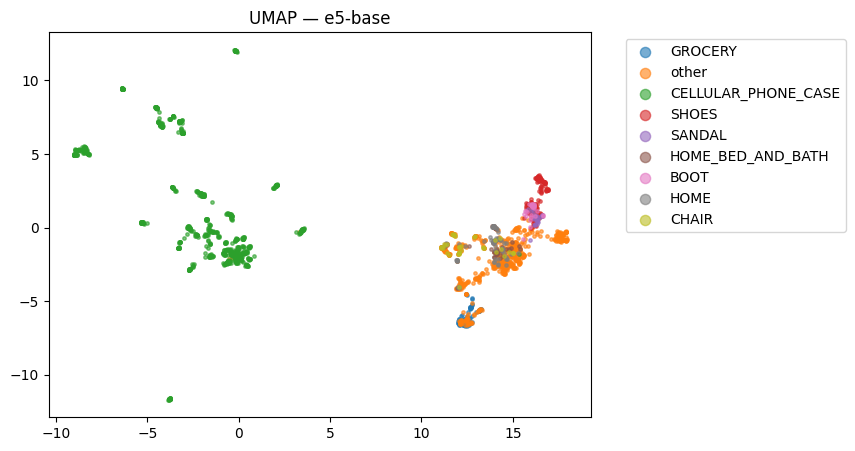

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


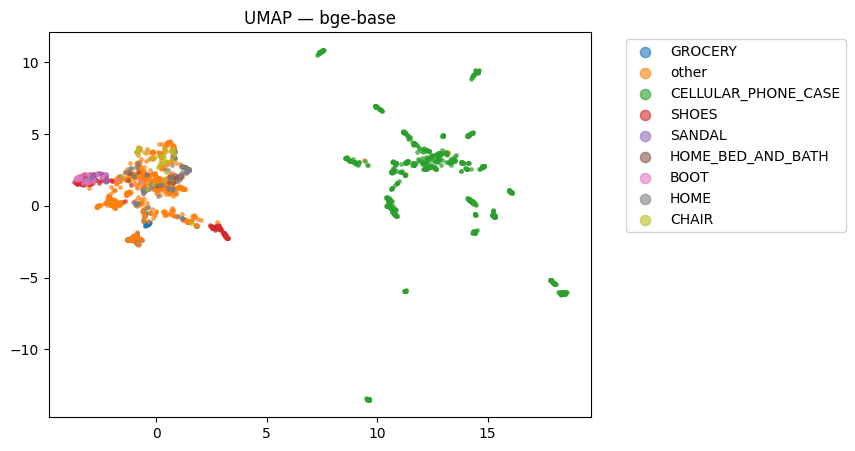

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


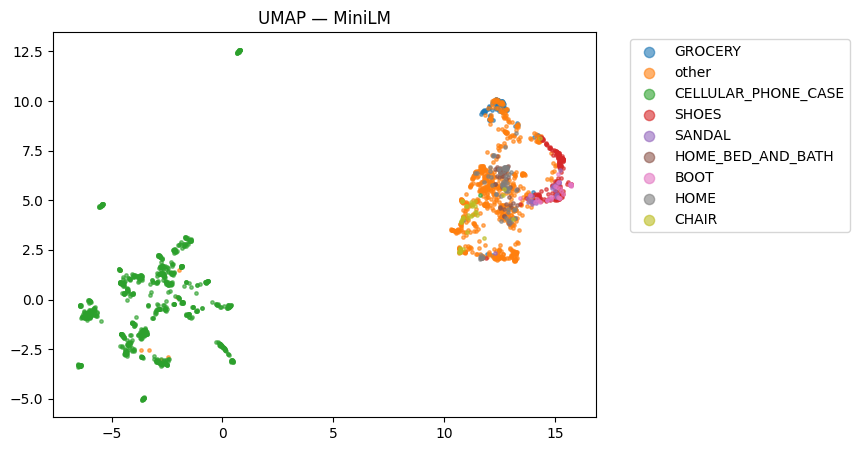

In [ ]:
import umap
import matplotlib.pyplot as plt

def extract_value(obj):
    if obj is None: return ''
    if isinstance(obj, str): return obj.strip()
    if isinstance(obj, (int, float, bool)): return str(obj)
    if isinstance(obj, dict):
        return extract_value(obj.get('value', '')) or ' '.join(extract_value(v) for v in obj.values())
    if isinstance(obj, list):
        return ' '.join(extract_value(el) for el in obj)
    return ''

# If your sample has product_type JSON, normalize it
if 'product_type' in sample.columns:
    sample['_label'] = sample['product_type'].apply(extract_value).str.strip()

def umap_plot(emb, labels, title):
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=SEED)
    Z = reducer.fit_transform(emb)
    # Map top few categories to colors
    cats = pd.Series(labels).fillna('')
    top = cats.value_counts().head(8).index
    col = cats.apply(lambda x: x if x in top else 'other')
    fig, ax = plt.subplots(figsize=(7,5))
    for c in col.unique():
        idx = (col == c).values
        ax.scatter(Z[idx,0], Z[idx,1], s=6, alpha=0.6, label=c)
    ax.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title(title)
    plt.show()

for name in ENCODERS.keys():
    umap_plot(EMB[(name,'docs')], sample['_label'].tolist(), title=f'UMAP — {name}')

## 10. Save artifacts
Persist embeddings and a compact product table for later ANN indexing.

In [ ]:
OUT = DATA_DIR / 'embeddings'
OUT.mkdir(exist_ok=True)
meta = sample[['item_name','product_type','text_for_embed']].copy()
meta.to_parquet(OUT / 'sample_meta.parquet')
for name in ENCODERS.keys():
    np.save(OUT / f'{name}_docs.npy', EMB[(name,'docs')])
    np.save(OUT / f'{name}_queries.npy', EMB[(name,'queries')])
print('Saved to', OUT)

Saved to data_abo/embeddings

## 11. Next steps
- Replace synthetic queries with a labeled eval set (query → relevant product IDs).
- Try **hybrid search**: BM25 vs vector, score fusion.
- Add a **cross-encoder reranker** on top-K and re-measure metrics.
- Add **image captions** and compare text-only vs text+captions.
- (Optional) Try quantized encoders for speed; log latency per model.